In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

In [2]:
df_obs = pd.read_csv("/Net/Groups/BSI/work_scratch/ppapastefanou/atto_summerschool_25/data/ATTO_evaluation.csv")

In [3]:
base_path = '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics'
df_best_hydraulics = pd.read_csv(os.path.join(base_path, "post_process", "parameters_best_t.csv"))

In [4]:
base_path = '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_03'
df_best_std= pd.read_csv(os.path.join(base_path, "post_process", "parameters_best_t.csv"))

In [6]:
base_path_output= '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output'
out = 1696
ds_mod_ass = xr.open_dataset(os.path.join(base_path_output, str(out),"Q_ASSIMI_fluxnetdata_timestep.nc"))


In [9]:
ds_mod_ass['gpp_avg'].units

'micro mol m-2 s-1'

In [5]:
df_best_std.sort_values(by='rmse_doy')

,id,sand_fracs,fid,clay_fracs,fresp,rmse_year_doy,rmse_doy
58,58,0.204,58,0.317,0.184,3.723667,1.225535
97,97,0.218,97,0.332,0.234,3.741811,1.245759
86,86,0.227,86,0.327,0.328,3.744993,1.249244
17,17,0.231,17,0.341,0.230,3.756018,1.261493
84,84,0.238,84,0.349,0.170,3.765388,1.271850
...,...,...,...,...,...,...,...
20,20,0.397,20,0.553,0.283,3.934010,1.470340
75,75,0.346,75,0.588,0.204,3.935619,1.472754
56,56,0.388,56,0.575,0.332,3.966355,1.511177
82,82,0.391,82,0.581,0.173,3.985322,1.535262


In [6]:
df_best_hydraulics.sort_values(by='rmse_doy')

,id,sand_fracs,fid,clay_fracs,fresp,kappa_stem,k_xylem_sat,psi50_close,root_dist,root_scale,rmse_year_doy,rmse_doy
1696,1696,0.255,1696,0.350,0.202,196.52514,9.65243,-1.68489,1.84283,52.19656,3.680245,1.106722
1588,1588,0.209,1588,0.391,0.226,260.77661,8.82008,-1.69680,1.51690,45.62915,3.678880,1.106793
1624,1624,0.266,1624,0.412,0.287,217.93918,9.26049,-1.69006,1.58876,57.32073,3.684100,1.106992
4180,4180,0.216,4180,0.394,0.263,154.55756,9.50577,-1.69061,1.98248,52.38192,3.679429,1.107082
1784,1784,0.226,1784,0.355,0.278,139.97369,9.01895,-1.69167,1.94815,44.15937,3.677654,1.107221
...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2872,0.204,2872,0.478,0.277,179.47045,5.70665,-1.00386,2.71773,11.98231,3.863670,1.457153
1010,1010,0.244,1010,0.465,0.242,220.78027,8.56028,-1.04039,2.87032,10.75440,3.858304,1.457269
2271,2271,0.278,2271,0.488,0.212,274.44146,9.42120,-1.02369,2.84188,13.53812,3.861917,1.457819
3425,3425,0.281,3425,0.455,0.241,222.45413,5.81278,-1.02697,2.75469,11.62184,3.866740,1.466417


In [7]:
def compute_metrics_for(base_path_output, out):
    
    ds_mod_ass = xr.open_dataset(os.path.join(base_path_output, str(out),"Q_ASSIMI_fluxnetdata_timestep.nc"))
    ds_mod_veg = xr.open_dataset(os.path.join(base_path_output,str(out), "VEG_fluxnetdata_timestep.nc"))
    ds_mod_sb  = xr.open_dataset(os.path.join(base_path_output,str(out), "SB_fluxnetdata_timestep.nc"))
    
    
    df_mod = ds_mod_veg['npp_avg'].to_pandas().to_frame()
    df_mod['gpp_avg'] = ds_mod_ass['gpp_avg']
    df_mod['nee_avg'] = -(ds_mod_veg['npp_avg'] -ds_mod_sb['het_respiration_avg'] )
    
    
    df_mod['Year'] = df_mod.index.year
    df_mod['day_of_year_adj'] = df_mod.index.dayofyear
    df_mod['Hour'] = df_mod.index.hour
    df_mod['Minute'] = df_mod.index.minute
    
    
    df_merged = pd.merge(
    df_mod,
    df_obs,
    on=["Year", "day_of_year_adj", "Hour", "Minute"],
    how="inner"   # or "outer", "left", "right" depending on your need
                        )

    df_merged['datetime'] = (
        pd.to_datetime(df_merged['Year'].astype(str), format='%Y')  # start of the year
        + pd.to_timedelta(df_merged['day_of_year_adj'], unit='D')  # adjust day of year
        + pd.to_timedelta(df_merged['Hour'], unit='h')
        + pd.to_timedelta(df_merged['Minute'], unit='m')
    )
    df_merged.set_index('datetime', inplace=True)
    
    dfm = df_merged.groupby([df_merged.index.day_of_year]).agg(
    nee_mean_mod=("nee_avg", "mean"),
    nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
    nee_median_mod=("nee_avg", "median"),
    nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
    
    nee_mean_obs=("NEE_U50_orig", "mean"),
    nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
    nee_median_obs=("NEE_U50_orig", "median"),
    nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
)
    ds_mod_ass.close()
    ds_mod_sb.close()
    ds_mod_veg.close()
    return dfm
    

In [8]:
def compute_metrics_ym_for(base_path_output, out):
    
    ds_mod_ass = xr.open_dataset(os.path.join(base_path_output, str(out),"Q_ASSIMI_fluxnetdata_timestep.nc"))
    ds_mod_veg = xr.open_dataset(os.path.join(base_path_output,str(out), "VEG_fluxnetdata_timestep.nc"))
    ds_mod_sb  = xr.open_dataset(os.path.join(base_path_output,str(out), "SB_fluxnetdata_timestep.nc"))
    
    
    df_mod = ds_mod_veg['npp_avg'].to_pandas().to_frame()
    df_mod['gpp_avg'] = ds_mod_ass['gpp_avg']
    df_mod['nee_avg'] = -(ds_mod_veg['npp_avg'] -ds_mod_sb['het_respiration_avg'] )
    
    
    df_mod['Year'] = df_mod.index.year
    df_mod['day_of_year_adj'] = df_mod.index.dayofyear
    df_mod['Hour'] = df_mod.index.hour
    df_mod['Minute'] = df_mod.index.minute
    
    
    df_merged = pd.merge(
    df_mod,
    df_obs,
    on=["Year", "day_of_year_adj", "Hour", "Minute"],
    how="inner"   # or "outer", "left", "right" depending on your need
                        )

    df_merged['datetime'] = (
        pd.to_datetime(df_merged['Year'].astype(str), format='%Y')  # start of the year
        + pd.to_timedelta(df_merged['day_of_year_adj'], unit='D')  # adjust day of year
        + pd.to_timedelta(df_merged['Hour'], unit='h')
        + pd.to_timedelta(df_merged['Minute'], unit='m')
    )
    df_merged.set_index('datetime', inplace=True)
    
    
    dfm = df_merged.groupby([df_merged.index.year, df_merged.index.month]).agg(
        nee_mean_mod=("nee_avg", "mean"),
        nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
        nee_median_mod=("nee_avg", "median"),
        nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
        
        nee_mean_obs=("NEE_U50_orig", "mean"),
        
        nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
        nee_median_obs=("NEE_U50_orig", "median"),
        nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
    )
    
    dfm.index = pd.to_datetime({
    "year": dfm.index.get_level_values(0),
    "month": dfm.index.get_level_values(1),
    "day": 1
})
    

    ds_mod_ass.close()
    ds_mod_sb.close()
    ds_mod_veg.close()
    return dfm

In [41]:
def compute_metrics_ts_for(base_path_output, out):
    
    ds_mod_ass = xr.open_dataset(os.path.join(base_path_output, str(out),"Q_ASSIMI_fluxnetdata_timestep.nc"))
    ds_mod_veg = xr.open_dataset(os.path.join(base_path_output,str(out), "VEG_fluxnetdata_timestep.nc"))
    ds_mod_sb  = xr.open_dataset(os.path.join(base_path_output,str(out), "SB_fluxnetdata_timestep.nc"))
    
    
    df_mod = ds_mod_veg['npp_avg'].to_pandas().to_frame()
    df_mod['gpp_avg'] = ds_mod_ass['gpp_avg']
    df_mod['nee_avg'] = -(ds_mod_veg['npp_avg'] -ds_mod_sb['het_respiration_avg'] )
    
    
    df_mod['Year'] = df_mod.index.year
    df_mod['day_of_year_adj'] = df_mod.index.dayofyear
    df_mod['Hour'] = df_mod.index.hour
    df_mod['Minute'] = df_mod.index.minute
    
    
    df_merged = pd.merge(
    df_mod,
    df_obs,
    on=["Year", "day_of_year_adj", "Hour", "Minute"],
    how="inner"   # or "outer", "left", "right" depending on your need
                        )

    df_merged['datetime'] = (
        pd.to_datetime(df_merged['Year'].astype(str), format='%Y')  # start of the year
        + pd.to_timedelta(df_merged['day_of_year_adj'], unit='D')  # adjust day of year
        + pd.to_timedelta(df_merged['Hour'], unit='h')
        + pd.to_timedelta(df_merged['Minute'], unit='m')
    )
    df_merged.set_index('datetime', inplace=True)
    
    
    dfm = df_merged.groupby([df_merged.index.hour, df_merged.index.minute]).agg(
        nee_mean_mod=("nee_avg", "mean"),
        nee_q25_mod=("nee_avg", lambda x: x.quantile(0.25)),
        nee_median_mod=("nee_avg", "median"),
        nee_q75_mod=("nee_avg", lambda x: x.quantile(0.75)),
        
        nee_mean_obs=("NEE_U50_orig", "mean"),
        
        nee_q25_obs=("NEE_U50_orig", lambda x: x.quantile(0.25)),
        nee_median_obs=("NEE_U50_orig", "median"),
        nee_q75_obs=("NEE_U50_orig", lambda x: x.quantile(0.75)),
    )
    
    dfm.index = pd.to_datetime({
    "year": 2000,
    "month": 1,
    "day": 1, 
    "hour" :dfm.index.get_level_values(0),
    "minute": dfm.index.get_level_values(1)
})


    ds_mod_ass.close()
    ds_mod_sb.close()
    ds_mod_veg.close()
    return dfm

In [ ]:
df_best_std = compute_metrics_for('/Net/Groups/BSI/scratch/pp('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output', 1696)apastefanou/simulations/QPy/ATTO_example_03/output', 58)
df_best_hyd = compute_metrics_for

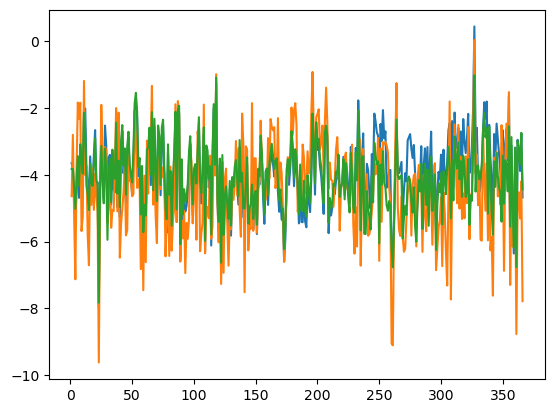

In [17]:
plt.plot(df_best_std['nee_mean_mod'])
plt.plot(df_best_std['nee_mean_obs'])
plt.plot(df_best_hyd['nee_mean_mod'])

In [18]:
df_best_std["week"] = ((df_best_std.index - 1) // 7) + 1
df_best_std_week = df_best_std.groupby("week").mean(numeric_only=True)

df_best_hyd["week"] = ((df_best_hyd.index - 1) // 7) + 1
df_best_hyd_week = df_best_hyd.groupby("week").mean(numeric_only=True)

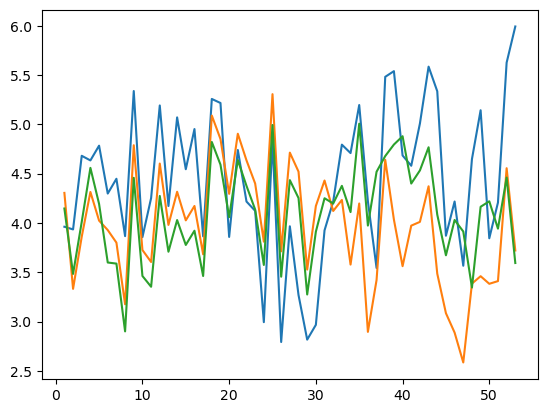

In [19]:
plt.plot(-df_best_std_week['nee_mean_obs'], label= 'Obs')
plt.plot(-df_best_std_week['nee_mean_mod'], label= 'QUINCY-std' )
plt.plot(-df_best_hyd_week['nee_mean_mod'], label= 'QUINCY-hyd')

In [20]:
# Convert DOY → datetime (use a leap year if you have 366 days)
year = 2020
df_best_std["date"] = pd.to_datetime(
    df_best_std.index.astype(str) + f"-{year}", 
    format="%j-%Y"
)
df_best_std["month"] = df_best_std["date"].dt.month
df_best_std_month =  df_best_std.groupby("month").mean(numeric_only=True)

df_best_hyd["date"] = pd.to_datetime(
    df_best_hyd.index.astype(str) + f"-{year}", 
    format="%j-%Y"
)
df_best_hyd["month"] = df_best_hyd["date"].dt.month
df_best_hyd_month =  df_best_hyd.groupby("month").mean(numeric_only=True)

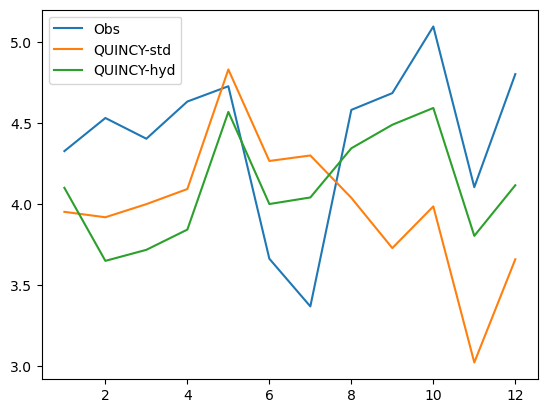

In [21]:
plt.plot(-df_best_std_month['nee_mean_obs'], label= 'Obs')
plt.plot(-df_best_std_month['nee_mean_mod'], label= 'QUINCY-std' )
plt.plot(-df_best_hyd_month['nee_mean_mod'], label= 'QUINCY-hyd')
plt.legend()

In [22]:
df_best_std = compute_metrics_ym_for('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_03/output', 58)
df_best_hyd = compute_metrics_ym_for('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output', 1696)

In [34]:
df_best_std.index

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', length=108, freq=None)

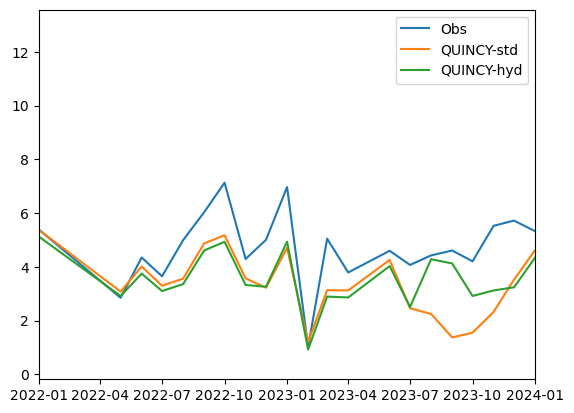

In [23]:
plt.plot(df_best_std.index,-df_best_std['nee_mean_obs'], label= 'Obs')
plt.plot(df_best_std.index, -df_best_std['nee_mean_mod'], label= 'QUINCY-std' )
plt.plot(df_best_std.index,-df_best_hyd['nee_mean_mod'], label= 'QUINCY-hyd')
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2024-01-01"))
plt.legend()

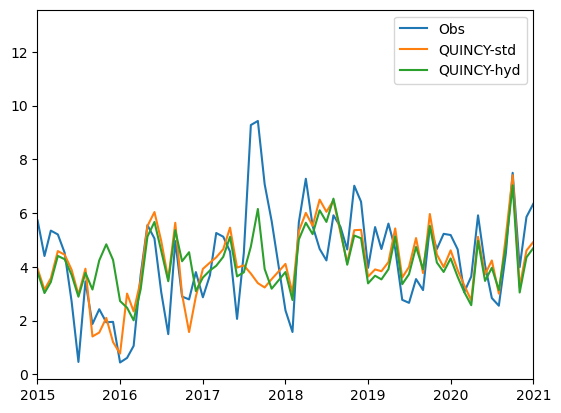

In [24]:
plt.plot(df_best_std.index,-df_best_std['nee_mean_obs'], label= 'Obs')
plt.plot(df_best_std.index, -df_best_std['nee_mean_mod'], label= 'QUINCY-std' )
plt.plot(df_best_std.index,-df_best_hyd['nee_mean_mod'], label= 'QUINCY-hyd')
plt.xlim(pd.to_datetime("2015-01-01"), pd.to_datetime("2021-01-01"))
plt.legend()

In [25]:
df_best_std = compute_metrics_ts_for('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_03/output', 58)
df_best_hyd = compute_metrics_ts_for('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output', 1696)

NameError: name 'compute_metrics_ts_for' is not defined

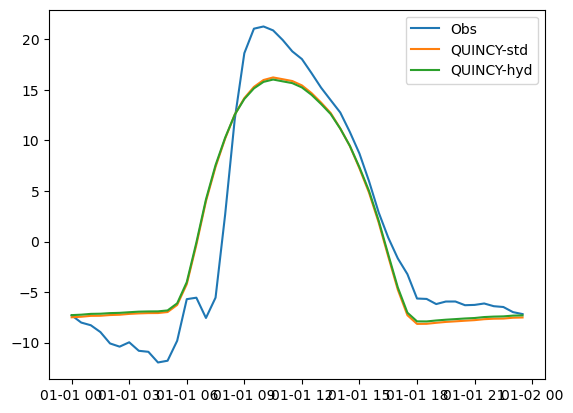

In [43]:
plt.plot(df_best_std.index,-df_best_std['nee_mean_obs'], label= 'Obs')
plt.plot(df_best_std.index, -df_best_std['nee_mean_mod'], label= 'QUINCY-std' )
plt.plot(df_best_std.index,-df_best_hyd['nee_mean_mod'], label= 'QUINCY-hyd')
plt.legend()

In [29]:
def compute_metrics_ym_for_var(base_path_output, out, cat, varname):
    
    ds_mod_ass = xr.open_dataset(os.path.join(base_path_output, str(out),f"{cat}_fluxnetdata_timestep.nc"))    
    
    df_mod = ds_mod_ass[varname].to_pandas().to_frame()   
    df_mod['Year'] = df_mod.index.year
    df_mod['day_of_year_adj'] = df_mod.index.dayofyear
    df_mod['Hour'] = df_mod.index.hour
    df_mod['Minute'] = df_mod.index.minute   
    df_merged = df_mod

    df_merged['datetime'] = (
        pd.to_datetime(df_merged['Year'].astype(str), format='%Y')  # start of the year
        + pd.to_timedelta(df_merged['day_of_year_adj'], unit='D')  # adjust day of year
        + pd.to_timedelta(df_merged['Hour'], unit='h')
        + pd.to_timedelta(df_merged['Minute'], unit='m')
    )
    df_merged.set_index('datetime', inplace=True)
    
    
#     dfm = df_merged.groupby([df_merged.index.year, df_merged.index.month]).agg(
#         var_mean_mod=(varname, "mean"),
#         var_q25_mod=(varname, lambda x: x.quantile(0.25)),
#         var_median_mod=(varname, "median"),
#         var_q75_mod=(varname, lambda x: x.quantile(0.75)),
#     )
    
#     dfm.index = pd.to_datetime({
#     "year": dfm.index.get_level_values(0),
#     "month": dfm.index.get_level_values(1),
#     "day": 1
# })
   
    
    dfm = df_merged.groupby([df_merged.index.day_of_year]).agg(
        var_mean_mod=(varname, "mean"),
        var_q25_mod=(varname, lambda x: x.quantile(0.25)),
        var_median_mod=(varname, "median"),
        var_q75_mod=(varname, lambda x: x.quantile(0.75)),
    )
    
    # dfm.index = pd.to_datetime({
    # "year": dfm.index.get_level_values(0),
    # "month": dfm.index.get_level_values(1),
    # "day": 1
    #})
    


    ds_mod_ass.close()
    return dfm

In [31]:
df_best_psi_stem = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output', 1696, 'PHYD', 'psi_stem_avg')
df_best_psi_leaf = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_05_hydraulics/output', 1696, 'PHYD', 'psi_leaf_avg')

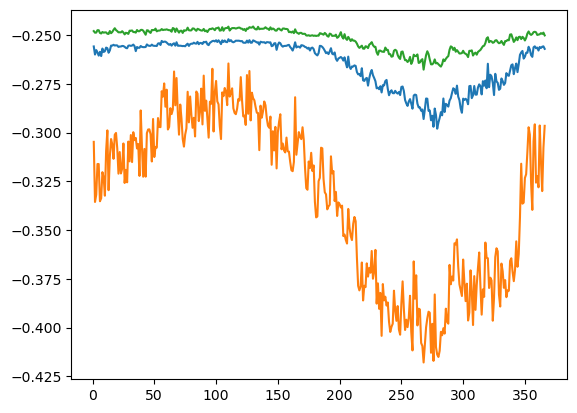

In [32]:
plt.plot(df_best_psi_leaf['var_median_mod'])
plt.plot(df_best_psi_leaf['var_q25_mod'])
plt.plot(df_best_psi_leaf['var_q75_mod'])
#plt.plot(df_best_psi_stem['var_mean_mod'])

In [81]:
df_best_sap = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_04_hydraulics/output', 762, 'stem_flow_avg')
df_best_G = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_04_hydraulics/output', 762, 'G_avg')

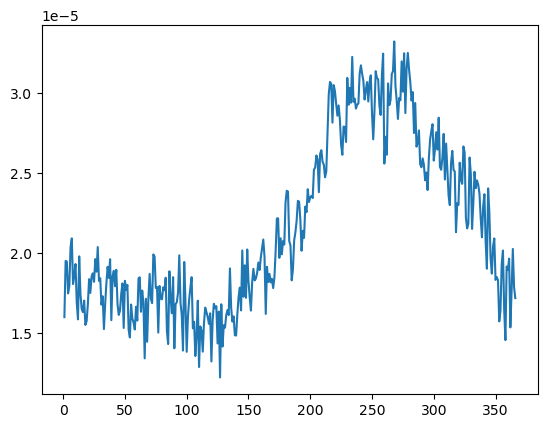

In [80]:
plt.plot(df_best_sap['var_mean_mod'])
# plt.plot(df_best_sap['var_q25_mod'])
# plt.plot(df_best_sap['var_q75_mod'])

In [86]:
df_best_hyd_trans = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_04_hydraulics/output', 762, 'SPQ', 'transpiration_avg')
df_best_std_trans = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_03/output', 58, 'SPQ', 'transpiration_avg')


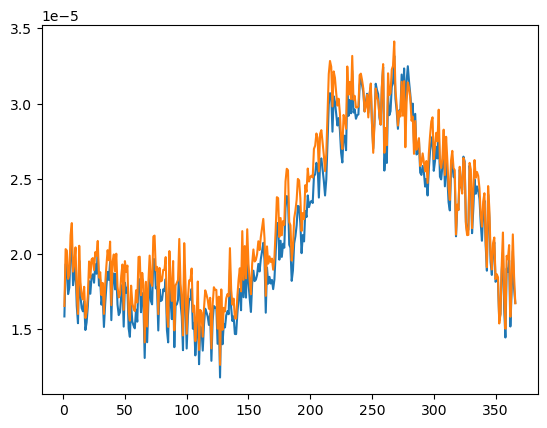

In [89]:
plt.plot(df_best_hyd_trans['var_mean_mod'])
plt.plot(df_best_std_trans['var_mean_mod'])

In [92]:
df_best_hyd_trans = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_04_hydraulics/output', 762, 'Q_ASSIMI', 'beta_gs')
df_best_std_trans = compute_metrics_ym_for_var('/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/ATTO_example_03/output', 58, 'Q_ASSIMI', 'beta_gs')


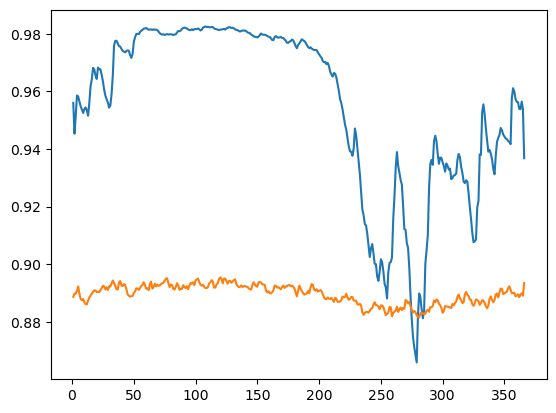

In [98]:
plt.plot(df_best_std_trans['var_mean_mod'])
plt.plot(df_best_hyd_trans['var_mean_mod'])
